In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse


In [65]:
# === Load Data ===
npz_path = r"C:\Users\victo\VSCode Folder\mass_spec_project\data\suspicious_peaks\suspicious_peaks.npz"
suspicious_peaks = np.load(npz_path, allow_pickle=True)

grids = suspicious_peaks["grids"]
mz_axes = suspicious_peaks["mz_axes"]
rt_axes = suspicious_peaks["rt_axes"]

print("Loaded:", suspicious_peaks.files)

Loaded: ['grids', 'mz_axes', 'rt_axes']


In [66]:
# === CONFIGURATION ===
MAX_COMPONENTS = 2
MIN_POINTS = 10

def delta_bic_to_confidence_score(delta_bic, saturation=20):
    return min(1.0, delta_bic / saturation) * 100

def get_high_intensity_seeds(X_filtered, intensity_filtered, n_seeds):
    sorted_idx = np.argsort(intensity_filtered)[::-1]
    return X_filtered[sorted_idx[:n_seeds]]

def get_distant_intensity_seeds(X_filtered, intensity_filtered):
    sorted_idx = np.argsort(intensity_filtered)[::-1]
    top_points = np.array(X_filtered[sorted_idx[:10]], dtype=np.float64)
    seed1 = top_points[0]
    seed2 = top_points[np.argmax(np.linalg.norm(top_points - seed1, axis=1))]
    return np.array([seed1, seed2])


In [ ]:
# === INITIALIZATION ===

def get_high_intensity_seeds(X_filtered, intensity_filtered, n_seeds):
    sorted_idx = np.argsort(intensity_filtered)[::-1]
    return X_filtered[sorted_idx[:n_seeds]]


def get_distant_intensity_seeds(X_filtered, intensity_filtered):
    sorted_idx = np.argsort(intensity_filtered)[::-1]
    top_points = np.array(X_filtered[sorted_idx[:10]], dtype=np.float64)
    seed1 = top_points[0]
    dists = np.linalg.norm(top_points - seed1, axis=1)
    seed2 = top_points[np.argmax(dists)]
    return np.array([seed1, seed2])


def delta_bic_to_confidence_score(delta_bic, saturation=20):
    return min(1.0, delta_bic / saturation) * 100


In [67]:
# === CORE FUNCTION ===
def process_region(index, grid, mz_axis, rt_axis):
    mz_coords, rt_coords = np.meshgrid(mz_axis, rt_axis, indexing='ij')
    X = np.column_stack([mz_coords.ravel(), rt_coords.ravel()])
    intensity = grid.ravel()

    min_intensity = grid.max() * 0.02
    mask = intensity > min_intensity
    X_filtered = X[mask]
    intensity_filtered = intensity[mask]

    if len(X_filtered) < MIN_POINTS:
        print(f"Region {index}: Too few points.")
        return None

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_filtered)

    gmms = []
    bics = []
    for k in range(1, MAX_COMPONENTS + 1):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
        seeds = (get_high_intensity_seeds(X_filtered, intensity_filtered, 1) 
                 if k == 1 else get_distant_intensity_seeds(X_filtered, intensity_filtered))
        gmm.means_init = scaler.transform(seeds)
        gmm.fit(X_scaled)
        gmms.append(gmm)
        bics.append(gmm.bic(X_scaled))

    best_k = np.argmin(bics) + 1
    best_gmm = gmms[best_k - 1]
    confidence = bics[0] - bics[1] if best_k == 2 else 0
    confidence_pct = delta_bic_to_confidence_score(confidence)

    print(f"Region {index}: Best model has {best_k} peak(s). ΔBIC = {confidence:.2f} → Confidence ≈ {confidence_pct:.1f}%")

    return {
        "index": index,
        "gmm": best_gmm,
        "scaler": scaler,
        "grid": grid,
        "mz_axis": mz_axis,
        "rt_axis": rt_axis,
        "confidence": confidence,
        "confidence_percent": confidence_pct,
        "bic_scores": bics,
        "best_k": best_k,
    }

In [68]:
# === PLOTTING ===
def plot_gmm_overlay(grid, mz_axis, rt_axis, gmm, scaler, region_idx):
    grid = np.array(grid, dtype=float)
    plt.figure(figsize=(8, 6))
    extent = [rt_axis[0], rt_axis[-1], mz_axis[0], mz_axis[-1]]
    plt.imshow(grid, extent=extent, origin='lower', aspect='auto', cmap='viridis')
    plt.title(f"Region {region_idx} – GMM Overlay ({gmm.n_components} component(s))")
    plt.xlabel("RT")
    plt.ylabel("m/z")
    plt.colorbar(label='Intensity')

    for mean, cov in zip(gmm.means_, gmm.covariances_):
        mean_orig = scaler.inverse_transform(mean.reshape(1, -1))[0]
        v, w = np.linalg.eigh(cov)
        v = 2.0 * np.sqrt(v)
        angle = np.degrees(np.arctan2(w[1, 0], w[0, 0]))
        scale_x, scale_y = scaler.scale_
        width = v[0] * scale_x
        height = v[1] * scale_y
        ell = Ellipse(xy=mean_orig[::-1], width=height, height=width,
                      angle=angle, edgecolor='red', fc='None', lw=2)
        plt.gca().add_patch(ell)
    plt.tight_layout()
    plt.show()

def plot_residual_heatmap(grid, mz_axis, rt_axis, gmm, scaler, region_idx):
    mz_coords, rt_coords = np.meshgrid(mz_axis, rt_axis, indexing='ij')
    X_grid = np.column_stack([mz_coords.ravel(), rt_coords.ravel()])
    X_scaled = scaler.transform(X_grid)

    recon = np.zeros(X_scaled.shape[0])
    for mean, cov, weight in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        rv = multivariate_normal(mean=mean, cov=cov)
        recon += weight * rv.pdf(X_scaled)

    recon_grid = recon.reshape(grid.shape)
    recon_grid *= grid.max() / recon_grid.max()
    residual = grid - recon_grid

    plt.figure(figsize=(8, 6))
    extent = [rt_axis[0], rt_axis[-1], mz_axis[0], mz_axis[-1]]
    plt.imshow(residual, extent=extent, origin='lower', aspect='auto', cmap='coolwarm')
    plt.title(f"Region {region_idx} – Residual Heatmap")
    plt.xlabel("RT")
    plt.ylabel("m/z")
    plt.colorbar(label='Residual (Actual - GMM)')
    plt.tight_layout()
    plt.show()


Region 0: Best model has 2 peak(s). ΔBIC = 44.46 → Confidence ≈ 100.0%


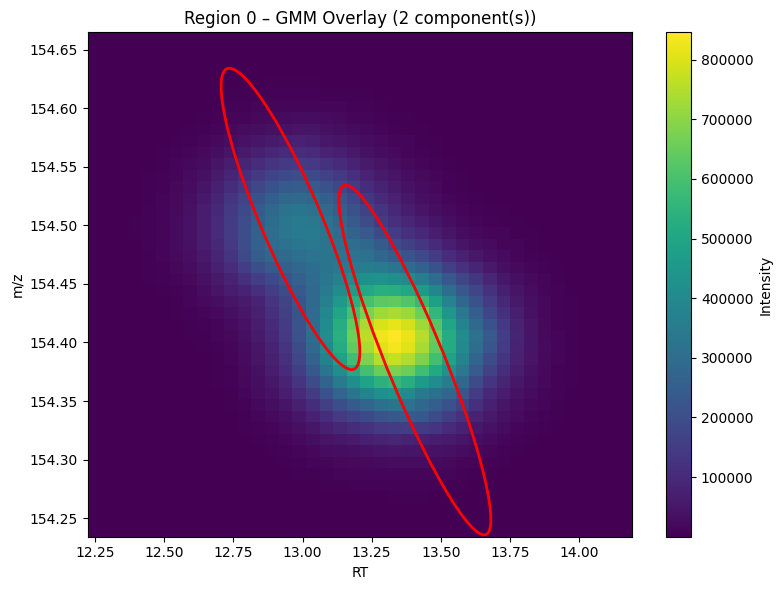

In [76]:
MIN_INTENSITY = 1e4  # Fixed threshold

for i, (grid, mz_axis, rt_axis) in enumerate(zip(grids, mz_axes, rt_axes)):
    mz_coords, rt_coords = np.meshgrid(mz_axis, rt_axis, indexing='ij')
    X = np.column_stack([mz_coords.ravel(), rt_coords.ravel()])
    intensity = grid.ravel()

    mask = intensity > MIN_INTENSITY
    X_filtered = X[mask]
    intensity_filtered = intensity[mask]

    if X_filtered.shape[0] < 10:
        print(f"Region {i}: Too few points to fit GMM.")
        continue

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_filtered)

    gmms = []
    bics = []
    for k in range(1, MAX_COMPONENTS + 1):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
        gmm.fit(X_scaled)  # ← NO custom seeds!
        gmms.append(gmm)
        bics.append(gmm.bic(X_scaled))

    best_k = np.argmin(bics) + 1
    best_gmm = gmms[best_k - 1]
    confidence = bics[0] - bics[1] if best_k == 2 else 0
    confidence_pct = delta_bic_to_confidence_score(confidence)

    results.append({
        "region_index": i,
        "best_k": best_k,
        "bic_scores": bics,
        "confidence": confidence,
        "confidence_percent": confidence_pct,
        "means": scaler.inverse_transform(best_gmm.means_),
        "covariances": best_gmm.covariances_,
        "weights": best_gmm.weights_,
    })

    print(f"Region {i}: Best model has {best_k} peak(s). ΔBIC = {confidence:.2f} → Confidence ≈ {confidence_pct:.1f}%")
    plot_gmm_overlay(grid, mz_axis, rt_axis, best_gmm, scaler, i)


In [73]:
for i, (grid, mz_axis, rt_axis) in enumerate(zip(grids, mz_axes, rt_axes)):
    # Step 1: Flatten data
    mz_coords, rt_coords = np.meshgrid(mz_axis, rt_axis, indexing='ij')
    X = np.column_stack([
        mz_coords.ravel(),
        rt_coords.ravel()
    ])
    intensity = grid.ravel()
    
    # Step 2: Remove near-zero points
    mask = intensity > MIN_INTENSITY
    X_filtered = X[mask]
    intensity_filtered = intensity[mask]
    
    if X_filtered.shape[0] < 10:
        print(f"Region {i}: Too few points to fit GMM.")
        continue

    # Step 3: Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_filtered)

    # Step 4: Fit 1- and 2-component GMMs
    gmms = []
    bics = []
    for k in range(1, MAX_COMPONENTS + 1):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
        gmm.fit(X_scaled)
        gmms.append(gmm)
        bics.append(gmm.bic(X_scaled))

    best_k = np.argmin(bics) + 1
    best_gmm = gmms[best_k - 1]
    confidence = bics[0] - bics[1] if best_k == 2 else 0
    confidence_pct = delta_bic_to_confidence_score(confidence)

    # Step 5: Save results (no need to inverse-transform for JSON/numpy format)
    results.append({
        "region_index": i,
        "best_k": best_k,
        "bic_scores": bics,
        "confidence": confidence,
        "confidence_percent": confidence_pct,
        "means": scaler.inverse_transform(best_gmm.means_),
        "covariances": best_gmm.covariances_,  # still in normalized space
        "weights": best_gmm.weights_,
    })

    print(f"Region {i}: Best model has {best_k} peak(s).\nΔBIC = {confidence:.2f} → Confidence ≈ {confidence_pct:.1f}%")




Region 0: Best model has 2 peak(s).
ΔBIC = 38.64 → Confidence ≈ 100.0%


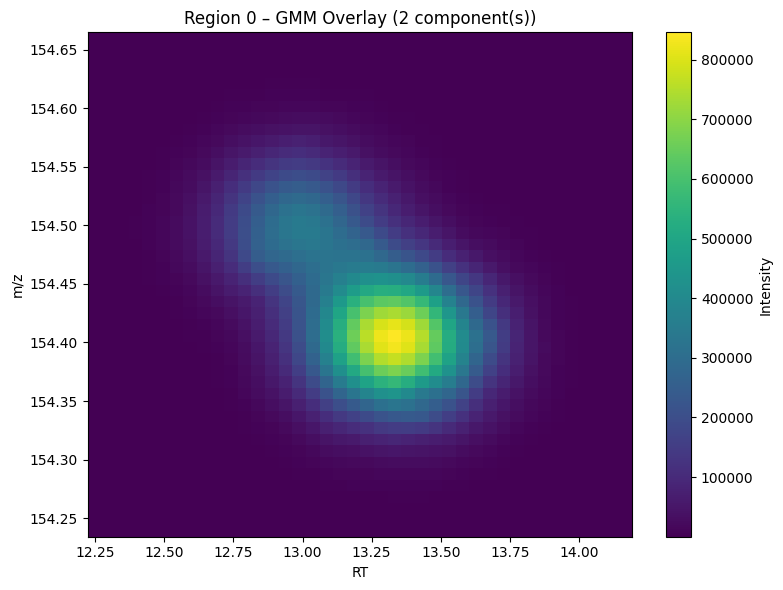

In [100]:
from matplotlib.patches import Ellipse

def plot_gmm_overlay(grid, mz_axis, rt_axis, gmm, scaler, region_idx):
    from matplotlib.patches import Ellipse

    grid = np.array(grid, dtype=float)
    plt.figure(figsize=(8, 6))
    extent = [rt_axis[0], rt_axis[-1], mz_axis[0], mz_axis[-1]]
    
    plt.imshow(grid, extent=extent, origin='lower', aspect='auto', cmap='viridis')
    plt.title(f"Region {region_idx} – GMM Overlay ({gmm.n_components} component(s))")
    plt.xlabel("RT")
    plt.ylabel("m/z")
    plt.colorbar(label='Intensity')

    for mean, cov in zip(gmm.means_, gmm.covariances_):
        # Transform mean back to original space
        mean_orig = scaler.inverse_transform(mean.reshape(1, -1))[0]

        # Compute ellipse parameters
        v, w = np.linalg.eigh(cov)
        v = 1.5 * np.sqrt(v)
        angle = np.degrees(np.arctan2(w[1, 0], w[0, 0]))

        # Transform ellipse axes from normalized back to original space
        scale_x = scaler.scale_[0]
        scale_y = scaler.scale_[1]
        width = v[0] * scale_x
        height = v[1] * scale_y

        ell = Ellipse(xy=mean_orig[::-1], width=height, height=width,
                      angle=angle, edgecolor='red', fc='None', lw=2)
        plt.gca().add_patch(ell)

    plt.tight_layout()
    plt.show()


# Optional: visualize
plot_gmm_overlay(grid, mz_axis, rt_axis, best_gmm, scaler, i)

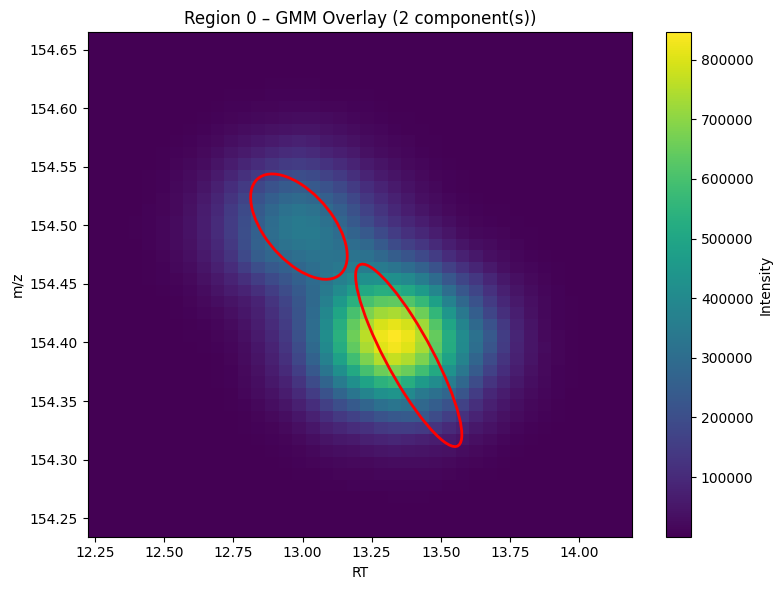

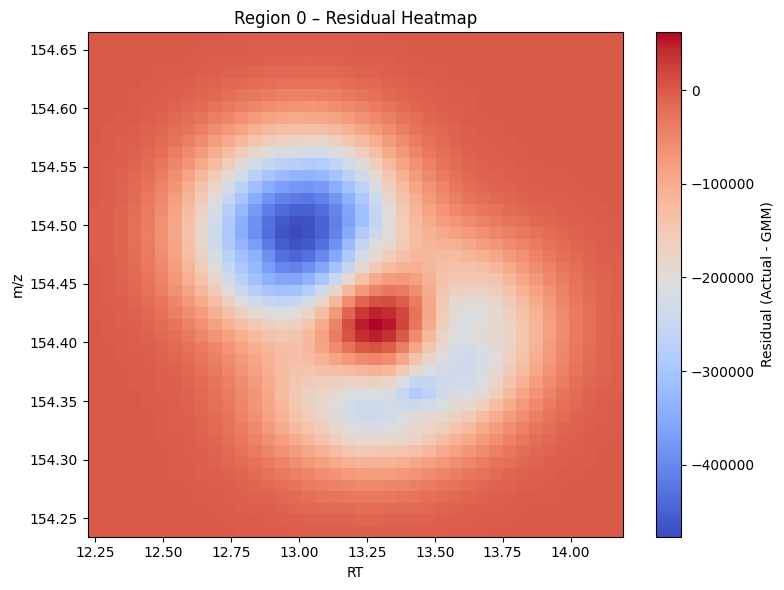

In [85]:
plot_gmm_overlay(grid, mz_axis, rt_axis, best_gmm, scaler, i)
plot_residual_heatmap(grid, mz_axis, rt_axis, best_gmm, scaler, i)


In [86]:
def plot_residual_heatmap(grid, mz_axis, rt_axis, gmm, scaler, region_idx):
    from scipy.stats import multivariate_normal

    grid = np.array(grid, dtype=float)
    mz_coords, rt_coords = np.meshgrid(mz_axis, rt_axis, indexing='ij')
    X_grid = np.column_stack([mz_coords.ravel(), rt_coords.ravel()])

    # Normalize grid coordinates
    X_scaled = scaler.transform(X_grid)

    # Evaluate GMM PDF over grid
    recon = np.zeros(X_scaled.shape[0])
    for mean, cov, weight in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        rv = multivariate_normal(mean=mean, cov=cov)
        recon += weight * rv.pdf(X_scaled)

    # Reshape and scale to match input intensity
    recon_grid = recon.reshape(grid.shape)
    recon_grid *= grid.max() / recon_grid.max()  # normalize intensity scale

    # Compute residuals
    residual = grid - recon_grid

    # Plot residual
    plt.figure(figsize=(8, 6))
    extent = [rt_axis[0], rt_axis[-1], mz_axis[0], mz_axis[-1]]
    plt.imshow(residual, extent=extent, origin='lower', aspect='auto', cmap='coolwarm')
    plt.title(f"Region {region_idx} – Residual Heatmap")
    plt.xlabel("RT")
    plt.ylabel("m/z")
    plt.colorbar(label='Residual (Actual - GMM)')
    plt.tight_layout()
    plt.show()


In [96]:
from matplotlib.patches import Ellipse

def plot_horizontal_gmm(grid, mz_axis, rt_axis, gmm, scaler, region_idx):
    grid = np.array(grid, dtype=float)
    plt.figure(figsize=(8, 6))
    extent = [rt_axis[0], rt_axis[-1], mz_axis[0], mz_axis[-1]]
    
    plt.imshow(grid, extent=extent, origin='lower', aspect='auto', cmap='viridis')
    plt.title(f"Region {region_idx} – GMM Overlay ({gmm.n_components} component(s))")
    plt.xlabel("RT")
    plt.ylabel("m/z")
    plt.colorbar(label='Intensity')

    rt_step = rt_axis[1] - rt_axis[0]
    mz_step = mz_axis[1] - mz_axis[0]
    print("RT step size:", rt_step, "| m/z step size:", mz_step)

    for mean in gmm.means_:
        mean_orig = scaler.inverse_transform(mean.reshape(1, -1))[0]
        rt, mz = mean_orig[1], mean_orig[0]
        print(f"Ellipse center at RT: {rt}, m/z: {mz/3}")

        ell = Ellipse(
            xy=(rt, mz),
            width=10 * rt_step,   # visibly large
            height=5 * mz_step,
            angle=0,
            edgecolor='red',
            fc='None',
            lw=2
        )
        plt.gca().add_patch(ell)

    plt.tight_layout()
    plt.show()


Region 0: Best model has 2 peak(s). ΔBIC = 30.11 → Confidence ≈ 100.0%
RT step size: 0.05050505050505194 | m/z step size: 0.010010010010006454
Ellipse center at RT: 12.986830357897194, m/z: 463.4965835025566
Ellipse center at RT: 13.384175132946384, m/z: 463.16705382415165


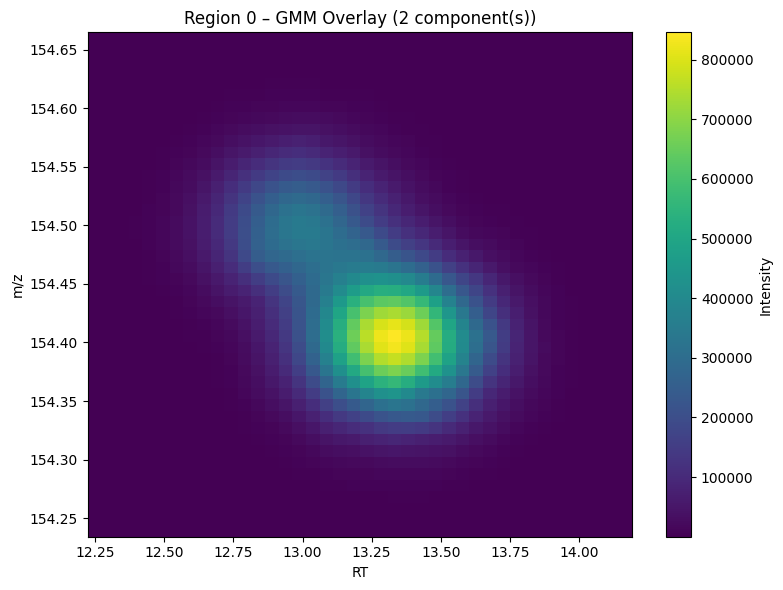

In [101]:
MIN_INTENSITY = 3e4  # Fixed threshold

for i, (grid, mz_axis, rt_axis) in enumerate(zip(grids, mz_axes, rt_axes)):
    mz_coords, rt_coords = np.meshgrid(mz_axis, rt_axis, indexing='ij')
    X = np.column_stack([mz_coords.ravel(), rt_coords.ravel()])
    intensity = grid.ravel()

    mask = intensity > MIN_INTENSITY
    X_filtered = X[mask]
    intensity_filtered = intensity[mask]

    if X_filtered.shape[0] < 10:
        print(f"Region {i}: Too few points to fit GMM.")
        continue

    X_aniso = X_filtered.copy()
    X_aniso[:, 0] *= 3.0   # m/z
    X_aniso[:, 1] *= 1.0   # RT

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_aniso)


    gmms = []
    bics = []
    for k in range(1, MAX_COMPONENTS + 1):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
        gmm.fit(X_scaled)
        gmms.append(gmm)
        bics.append(gmm.bic(X_scaled))

    best_k = np.argmin(bics) + 1
    best_gmm = gmms[best_k - 1]
    confidence = bics[0] - bics[1] if best_k == 2 else 0
    confidence_pct = delta_bic_to_confidence_score(confidence)

    results.append({
        "region_index": i,
        "best_k": best_k,
        "bic_scores": bics,
        "confidence": confidence,
        "confidence_percent": confidence_pct,
        "means": scaler.inverse_transform(best_gmm.means_),
        "covariances": best_gmm.covariances_,
        "weights": best_gmm.weights_,
    })

    print(f"Region {i}: Best model has {best_k} peak(s). ΔBIC = {confidence:.2f} → Confidence ≈ {confidence_pct:.1f}%")

    plot_horizontal_gmm(grid, mz_axis, rt_axis, best_gmm, scaler, i)
